In [7]:
import numpy as np
import matplotlib.pyplot as plt

from typing import Tuple

from tsp import TSP
from solvers import AntSystemSolver, AntColonySystemSolver
from visualization import *

In [8]:
def plot_gif(nodes, pheromones, iteration=None, save_dir='results/pheromones'):
    fig = plt.figure(2)
    plt.clf()
    ax = fig.add_subplot(111)
    ax.scatter(nodes[:,0], nodes[:,1])
    colors = plt.cm.jet(np.linspace(0, 1, 256))

    # normalizing pheromone matrix in the range [0, 255)
    if pheromones.min() == pheromones.max():
        pheromones_alpha = np.zeros(pheromones.shape)
    else:
        pheromones_alpha = (pheromones - pheromones.min()) / (pheromones.max() - pheromones.min())
    pheromones_color = (pheromones_alpha * 255).astype(int)
    
    for i in range(pheromones.shape[0]):
        for j in range(i+1, pheromones.shape[1]):
            x = nodes[[i, j]].T[0]
            y = nodes[[i, j]].T[1]
            edge_pheromone = pheromones_color[i,j]
            ax.plot(x, y, c=colors[edge_pheromone], alpha=pheromones_alpha[i, j])

    norm = mpl.colors.Normalize(vmin=0, vmax=1) 
    sm = plt.cm.ScalarMappable(cmap=plt.get_cmap('jet', 256), norm=norm) 
    sm.set_array([]) 

    ax.set_aspect('equal', adjustable='box')
    ax.set_xticks([])
    ax.set_yticks([])
    

    if save_dir is not None:
        plt.savefig(save_dir)
        plt.close()

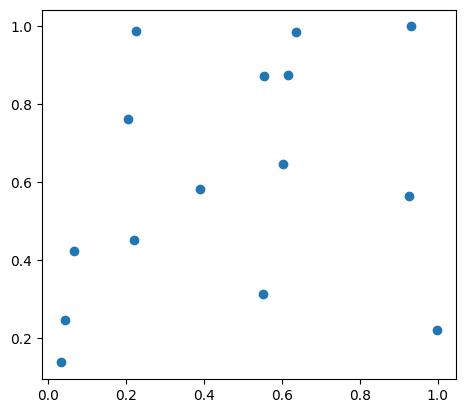

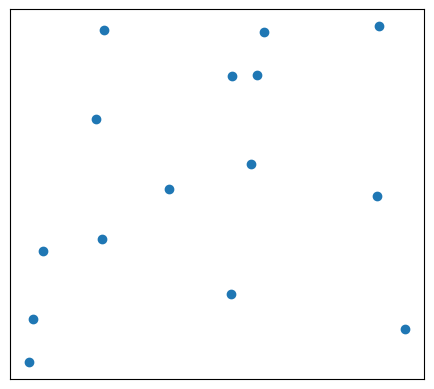

In [9]:
# debugging

# square
# cities = np.array([[2, 1], [2, 2], [1, 1], [1, 2]])
# tsp = TSP.from_instance(cities)

# circle
# cities = np.array([[0, 1], [0.25, 0.5], [0.3232, 0.3232], [0.5, 0.25], [0.6768, 0.3232], [0.75, 0.5], [1, 1]])
# tsp = TSP.from_instance(cities)

# random
tsp = TSP.random_instance(15)

solver = AntColonySystemSolver(tsp)

plot_solution(tsp.cities, save_dir=None)
plot_gif(tsp.cities, solver.pheromones, save_dir=None)

In [10]:
NUM_IT = 1000
least_cost = np.inf
avg_costs = {
    'train': [],
    'val': []
}
for it in range(NUM_IT):
    # sampling a batch of solutions for training
    train_tours = solver.sample(local_update_strategy='ACS')
    train_costs = tsp.evaluate(train_tours)
    avg_costs['train'].append(np.mean(train_costs))

    # getting a batch of solutions using greedy strategy for validation
    val_tours = solver.sample(strategy='greedy', apply_local_pheromone_update=False)
    val_costs = tsp.evaluate(val_tours)
    avg_costs['val'].append(np.mean(val_costs))

    # selecting the best tour from validation
    best_tour = val_tours[np.argmin(val_costs)]
    min_val_cost = np.min(val_costs)
    if min_val_cost < least_cost:
        least_cost = min_val_cost
        print(f'--> Best tour so far: {best_tour}, cost: {least_cost}, it: {it},')
    
    # plotting
    if it % 25 == 0:
        plot_solution(tsp.cities, val_tours[np.argmin(val_costs)], np.min(val_costs), save_dir=f'results/tours/tour_{it}')
        plot_gif(tsp.cities, solver.pheromones, iteration=it, save_dir=f'results/pheromones/gif_{str(it).zfill(4)}')
    
    # updating the pheromone matrix
    solver.update_pheromone(train_tours)

plot_mean_cost(avg_costs['val'], save_dir=f'results/costs/costs_{it}')
plt.close()

--> Best tour so far: [ 2 14  4  0 12  3 10  9  5  7 11  1 13  8  6], cost: 5.3070487566187845, it: 0,
--> Best tour so far: [ 4  0  2 14  9 12  3  1  5  8 13  7 11 10  6], cost: 5.126187369107481, it: 2,
--> Best tour so far: [13  1 10  6  7  8 11  3 12 14  9  5  2  0  4], cost: 5.075977330717142, it: 4,
--> Best tour so far: [ 0  4  2 14  9 12  3 13  5  8  1 10  7 11  6], cost: 5.003409872781919, it: 5,
--> Best tour so far: [ 4  0  2 14  9 12  3  1 13  5  8  7 10 11  6], cost: 4.8401510540134245, it: 7,
--> Best tour so far: [ 0  4  2 14  9 12  3  7  8  5  1 10 11 13  6], cost: 4.348153282682954, it: 8,
--> Best tour so far: [ 0  4  2 14 12  9  5  8 11  3 10  1  7 13  6], cost: 4.119338575860207, it: 559,


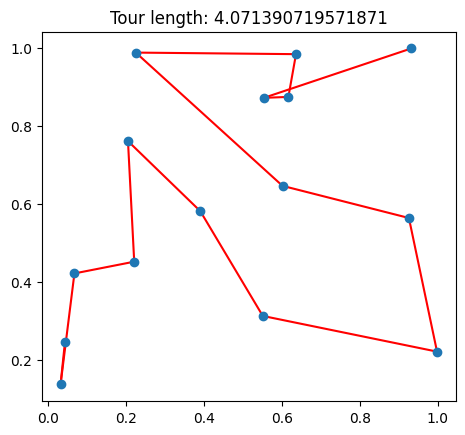

In [11]:
plot_solution(tsp.cities, solver.best_tour, solver.min_cost)

# Creating GIF

In [12]:
import imageio
import os
images = []
files = os.listdir('results/pheromones/')
files.sort()
for file in files:
    images.append(imageio.imread(os.path.join('results/pheromones/', file)))
imageio.mimsave('results/trails.gif', images, fps=5, loop=0)

/tmp/ipykernel_27377/1119161470.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(os.path.join('results/pheromones/', file)))
